## **LSTM** - Solar Flare from RHESSI Mission
* January  09°, 2025
#### ESCOM - IPN

#### *B.S. in Data Science* 
> Sanchez Garcia Miguel Alexander

#### **0° Introduction**

**a.** Get the **libraries** we are going to use

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

**b.** Import the data

In [64]:
data = pd.read_csv('hessi_flare_list_cleaned.csv')

In [65]:
data.tail(10)

,Flare,Date,Start,Peak,End,Dur_s,Peak_c/s,Total Counts,Energy keV,X Pos asec,Y Pos asec,Radial asec,AR,Flags
15728,11122301,2011-12-23,00:03:52,00:08:10,00:08:24,272.0,59.0,58054.0,6-12,-602,219,641.0,1384.0,A0 P1 Q1 SE
15729,11122365,2011-12-23,01:51:04,01:52:34,01:52:44,100.0,24.0,11213.0,6-12,-584,247,635.0,1384.0,A0 P1 Q1 SE
15730,11122369,2011-12-23,08:06:48,08:07:18,08:08:08,80.0,25.0,9903.0,6-12,-924,-310,975.0,1386.0,A0 P1
15731,11122326,2011-12-23,11:15:44,11:16:22,11:18:04,140.0,30.0,14573.0,6-12,-502,238,556.0,1384.0,A0 P1
15732,11122402,2011-12-24,01:26:56,01:28:10,01:29:08,132.0,34.0,15963.0,6-12,903,336,964.0,1376.0,A0 P1
15733,11122443,2011-12-24,01:46:24,01:46:54,01:47:24,60.0,18.0,5915.0,6-12,-913,-345,976.0,1386.0,A0 P1 Q1 SE
15734,11122685,2011-12-26,15:44:56,15:45:06,15:45:16,20.0,36.0,3881.0,6-12,-917,-363,986.0,0.0,A0 P1 Q1 SE
15735,11122782,2011-12-27,15:37:00,15:37:26,15:37:32,32.0,21.0,2961.0,6-12,-918,-378,993.0,1388.0,A0 P1
15736,11123108,2011-12-31,05:33:20,05:34:02,05:34:52,92.0,19.0,8061.0,6-12,-674,-399,783.0,1389.0,A0 P1
15737,14062601,2014-06-26,00:56:20,00:56:58,00:59:00,160.0,28.0,22811.0,6-12,-938,112,945.0,0.0,A0 P1


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Flare         15738 non-null  int64  
 1   Date          15738 non-null  object 
 2   Start         15738 non-null  object 
 3   Peak          15738 non-null  object 
 4   End           15738 non-null  object 
 5   Dur_s         15738 non-null  float64
 6   Peak_c/s      15738 non-null  float64
 7   Total Counts  15738 non-null  float64
 8   Energy keV    15738 non-null  object 
 9   X Pos asec    15738 non-null  int64  
 10  Y Pos asec    15738 non-null  int64  
 11  Radial asec   15738 non-null  float64
 12  AR            15738 non-null  float64
 13  Flags         15738 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 1.7+ MB


#### **1° Preparing Data**

**a.** Set Datetime as index

In [67]:
# Combine Date and Start Time columns
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Start'])

# Drop Date and Start columns
data = data.drop(['Date', 'Start'], axis=1)

# Set Datetime as index
data = data.set_index('Datetime')


**b.** Drop unnecesary colums

In [68]:
# Drop innecesary columns
data = data.drop(['Flare', 'Flags', 'Peak', 'End'], axis=1)

**c.** Encode Energy keV column

In [69]:
# Encode 'Energy keV' column using label encoding
label_encoder = LabelEncoder()

data['Energy keV'] = label_encoder.fit_transform(data['Energy keV'])


**d.** Drop innecesary rows

In [70]:
# Drop last row
data = data[:-1]

**e.** Boxplot of duration of solar flares

<Axes: ylabel='Dur_s_log1p'>

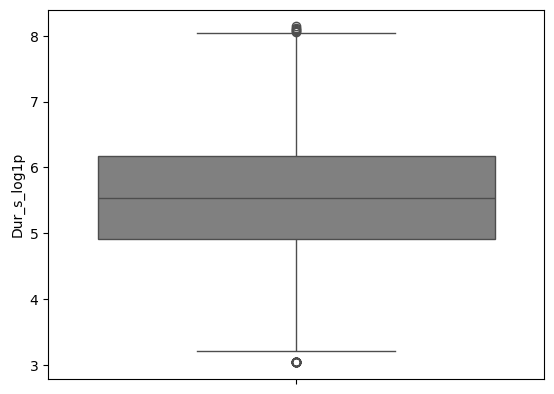

In [71]:
# Boxplot of duration (normalized)
data['Dur_s_log1p'] = np.log1p(data['Dur_s'])
sns.boxplot(data=data['Dur_s_log1p'], orient='v', color='gray')


**f.** Drop duration outliers

In [72]:
# Drop rows with duration (normalized) greater than 8 and less than 3
data = data[(data['Dur_s_log1p'] < 8) & (data['Dur_s_log1p'] > 3)]

# Drop 'Dur_s_log1p' column
data = data.drop(['Dur_s_log1p'], axis=1)

In [73]:
# Drop 'Dur_s' higher than 1000
#data = data[data['Dur_s'] < 1000]

In [74]:
# Only use data of 2002
data = data[data.index.year == 2002]

In [75]:
data

,Dur_s,Peak_c/s,Total Counts,Energy keV,X Pos asec,Y Pos asec,Radial asec,AR
Datetime,,,,,,,,
2002-02-12 02:15:24,624.0,46.0,75270.0,2,958,-118,965.0,9809.0
2002-02-12 02:49:04,104.0,20.0,6528.0,5,637,-100,645.0,0.0
2002-02-12 21:30:08,668.0,147.0,184773.0,1,597,-370,703.0,9811.0
2002-02-13 00:53:28,204.0,16.0,12070.0,1,-309,375,486.0,0.0
2002-02-13 02:48:56,100.0,13.0,4995.0,1,-385,299,488.0,9825.0
...,...,...,...,...,...,...,...,...
2002-12-31 07:00:12,508.0,500.0,420048.0,1,130,361,383.0,234.0
2002-12-31 06:55:32,280.0,45.0,50299.0,5,126,356,378.0,234.0
2002-12-31 05:06:36,692.0,16.0,46523.0,5,-968,148,980.0,0.0


**g.** Spliting the data

In [76]:
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [77]:
print(train.shape, test.shape)

(2956, 8) (740, 8)


**h.** Standarize the data

In [78]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#### **2° Training the model**

**a.** Define a function to slide bewteen dates

In [94]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

x_train,y_train=createXY(train_scaled,15)
x_test,y_test=createXY(test_scaled,15)

In [95]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2941, 15, 8) (2941,) (725, 15, 8) (725,)


**b.** Define the model

In [96]:
def build_lstm_model(input_shape, units=200, dropout_rate=0.3, learning_rate=0.0001):
    """
    Builds an LSTM model for time-series prediction.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).
        units (int): Number of LSTM units. Default is 50.
        dropout_rate (float): Dropout rate for regularization. Default is 0.2.
        learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.

    Returns:
        model: Compiled Keras model.
    """
    
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Second LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Dense output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Define the input shape
input_shape = (15, 8)  # (timesteps, features)

# Build the model
model = build_lstm_model(input_shape=input_shape)

# Print the model summary
model.summary()




/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 15, 200)        │       167,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 200)        │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,801 (1.87 MB)

 Trainable params: 489,001 (1.87 MB)

 Non-trainable params: 800 (3.12 KB)

**c.** Train the model

In [97]:
# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0555 - mae: 0.8120 - val_loss: 0.0215 - val_mae: 0.0990
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7709 - mae: 0.6949 - val_loss: 0.0208 - val_mae: 0.1018
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7338 - mae: 0.6781 - val_loss: 0.0211 - val_mae: 0.1086
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6600 - mae: 0.6454 - val_loss: 0.0280 - val_mae: 0.1233
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5815 - mae: 0.6065 - val_loss: 0.0277 - val_mae: 0.1320
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5555 - mae: 0.5838 - val_loss: 0.0330 - val_mae: 0.1310
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5097 - mae: 0.5620 - val_loss: 0.0356 - val_mae: 0.1566
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4972 - mae: 0.5524 - val_loss: 0.0385 - val_mae: 0.1476
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.487

**d.** Show the Loss function per Epoch

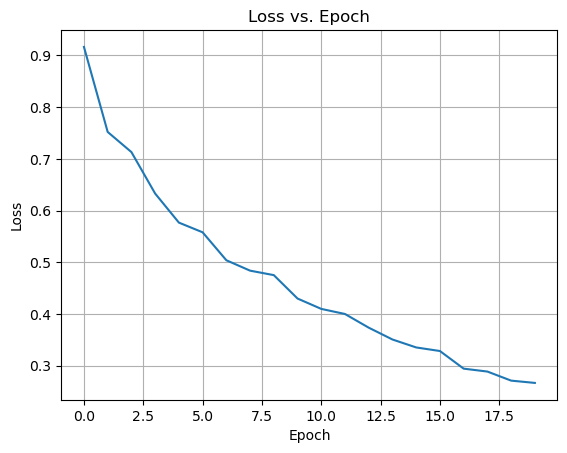

In [98]:
# Plot the loss vs. epoch
plt.plot(history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

**e.** Predict using the test data

In [99]:
predictions = model.predict(x_test)

print(predictions.shape)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(725, 1)


**f.** Set the dat again to original

In [100]:
prediction_copies_array = np.repeat(predictions, 8, axis=-1)

In [101]:
prediction_copies_array.shape

(725, 8)

In [102]:
pred = scaler.inverse_transform(prediction_copies_array)

In [103]:
original_copies_array = np.repeat(y_test,8, axis=-1)
true_values=scaler.inverse_transform(np.reshape(original_copies_array,(len(y_test),8)))

In [104]:
print('Predicted values:', pred[:,0])
print('True values:', true_values[:,0])

Predicted values: [-5.07979340e+02 -4.96806091e+02 -4.73301514e+02 -4.34956116e+02
 -5.09499695e+02 -4.42143311e+02 -3.83778381e+02 -3.24575745e+02
 -2.38904816e+02 -9.23641586e+01 -1.24199394e+02 -1.01639503e+02
 -1.00798666e+00  1.61370239e+01  1.77839294e+02  2.74257843e+02
  4.47977692e+02  6.14842224e+02  6.71632690e+02  6.37599304e+02
  5.75511475e+02  5.63103394e+02  5.34345581e+02  4.34332367e+02
  3.21965332e+02  2.62157715e+02  2.93033813e+02  2.60655731e+02
  2.17507339e+02  6.13251724e+01 -4.79038620e+01 -2.63464539e+02
 -4.43359375e+02 -4.84725067e+02 -4.36436493e+02 -4.76493164e+02
 -5.13728333e+02 -5.41482605e+02 -5.22675171e+02 -5.41991882e+02
 -5.55111511e+02 -5.60259155e+02 -5.46000366e+02 -5.70044373e+02
 -4.39224213e+02 -2.93903259e+02 -1.42461975e+02 -3.49417877e+01
  3.78547325e+01 -4.55534019e+01  1.34537535e+01  9.90001755e+01
  1.54049911e+02  2.24810989e+02  2.36009766e+02  1.61945908e+02
  5.43212280e+01 -3.03205395e+01 -1.19181458e+02 -5.96297989e+01
 -2.922

**g.** Calculate the MSE

In [105]:
# Calculate the Mean Squared Error
mse = mean_squared_error(true_values[:,0], pred[:,0])
print('Mean Squared Error:', mse)

Mean Squared Error: 339739.79797985696


In [106]:
aux_pred = pred[:,0]





**h.** Plot the spectre of the Predicted vs the Real

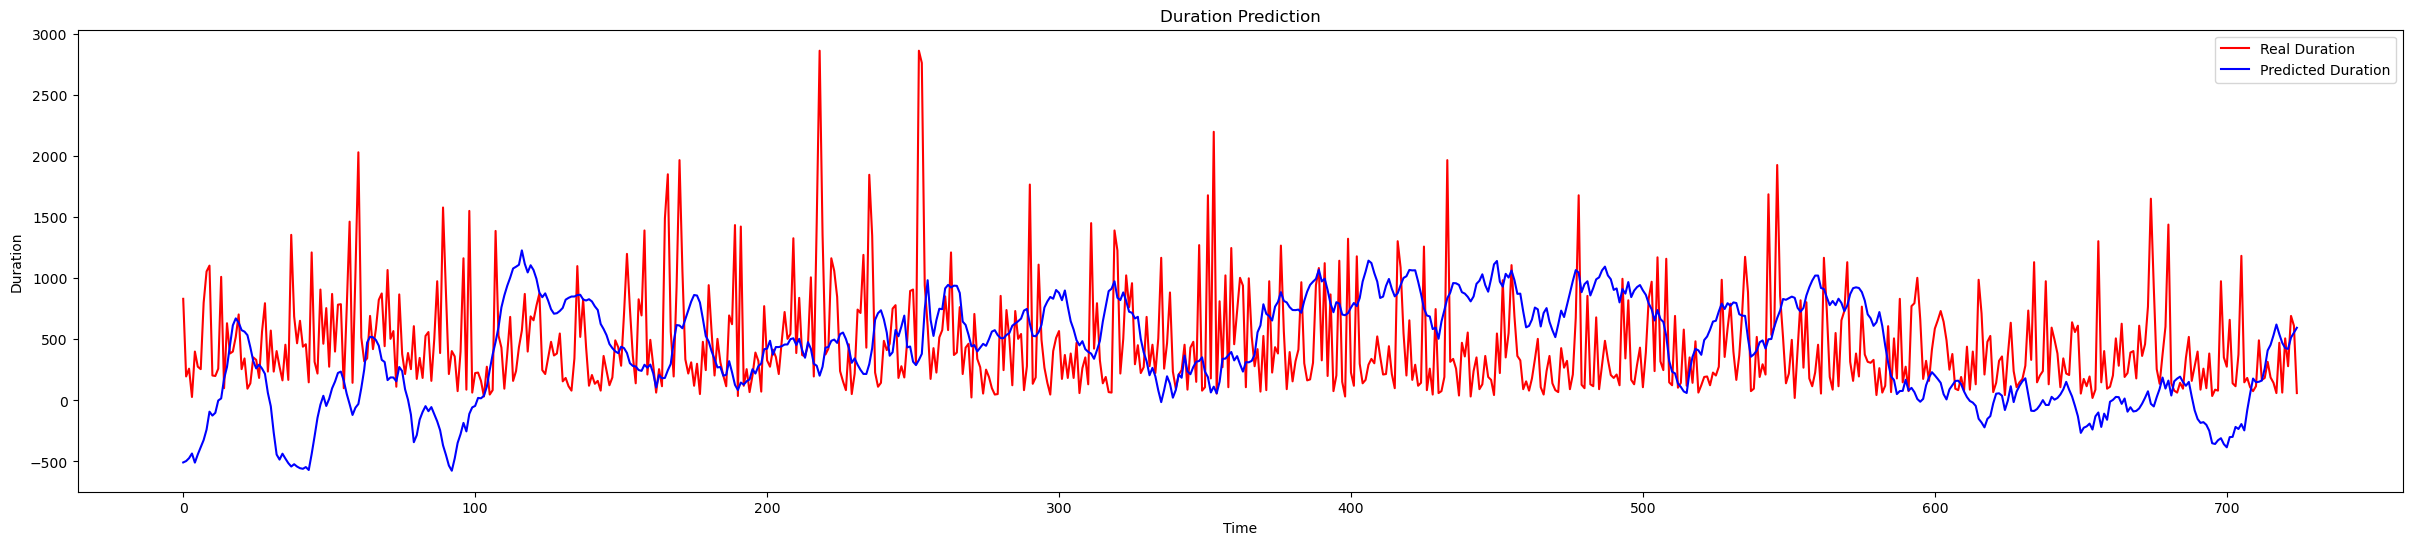

In [107]:
# Make figure larger
plt.figure(figsize=(30, 6))
plt.plot(true_values[:,0], color = 'red', label = 'Real Duration')
plt.plot(aux_pred, color = 'blue', label = 'Predicted Duration')
plt.title('Duration Prediction')
plt.xlabel('Time')
plt.ylabel('Duration')
plt.legend()
plt.show()